In [1]:
import ml_collections
from wavebench.dataloaders.rtc_loader import get_dataloaders_rtc_thick_lines
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device in use: {device}')

device in use: cuda:0


In [2]:
219 / 4

54.75

In [2]:
config = ml_collections.ConfigDict()

# dataset setting
config.sidelen = 128
config.train_batch_size = 8
config.eval_batch_size = 1
config.num_workers = 20

loaders = get_dataloaders_rtc_thick_lines(
    train_batch_size=config.train_batch_size,
    eval_batch_size=config.eval_batch_size,
    sidelen=config.sidelen,
    num_workers=config.num_workers)

train_loader = loaders['train']
test_loader = loaders['test']

# learning setting
config.num_epochs = 10
config.lr = 2e-4
config.eta_min = 1e-5 # the smallest learning rate in learning rate decay

In [24]:


loaders['train'].dataset.dataset.final[:10].max()

# a, b = loaders['train'].dataset.__getitem__(3000)

# a.max()

tensor(0.5897)

In [41]:


for i in range(28, 40000):
  a, b = loaders['train'].dataset.__getitem__(i)
  if a.abs().max() > 100:
    print(a.abs().max())
    print(i)
    break

tensor(176524.2344)
76


tensor(176524.2344)


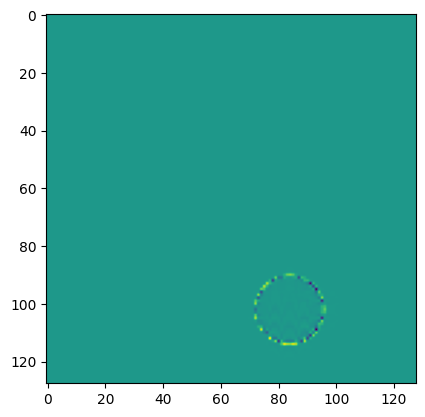

In [42]:
a, b = loaders['train'].dataset.__getitem__(76) # 27

print(a.abs().max())
plt.imshow(a.squeeze().numpy())

tensor(0.6358)


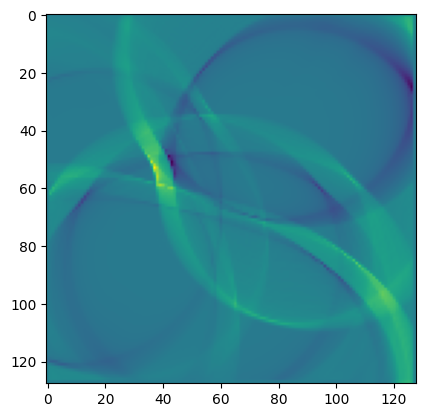

In [3]:
from wavebench.nn.unet import UNet
net = UNet(1, 1, 2).to(device)

# from neuralop.models import FNO2d

# model_config = { 'n_modes_width': 12,
#     'n_modes_height': 16,
#     'hidden_channels': 64,
#     # 'n_layers': 2,
#     # 'skip': 'linear',
#     'in_channels': 1,
#     'out_channels': 1}
# net = FNO2d(**model_config).to(device)

criterion = torch.nn.MSELoss()


optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    config.num_epochs*len(train_loader),
    eta_min=config.eta_min)

In [4]:
# loop over the dataset multiple epochs
for epoch in range(config.num_epochs):
    net.train()

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, targets]
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print statistics
        running_loss += loss.item()

    print(f'[{epoch + 1:02d}/{config.num_epochs:02d}]\
        loss: {running_loss / len(train_loader) :.4f}')
    running_loss = 0.0

print('Finished Training')

[01/10]        loss: 0.0274
[02/10]        loss: 0.0196
[03/10]        loss: 0.0154
[04/10]        loss: 0.0129
[05/10]        loss: 0.0114
[06/10]        loss: 0.0102
[07/10]        loss: 0.0091
[08/10]        loss: 0.0084
[09/10]        loss: 0.0079
[10/10]        loss: 0.0077
Finished Training


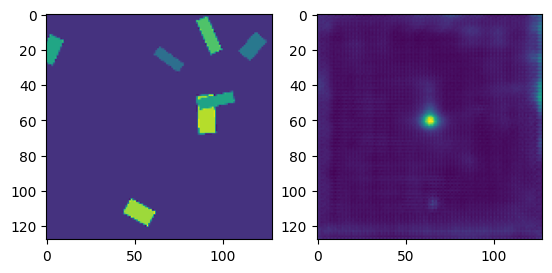

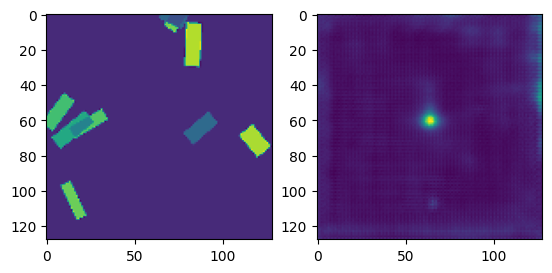

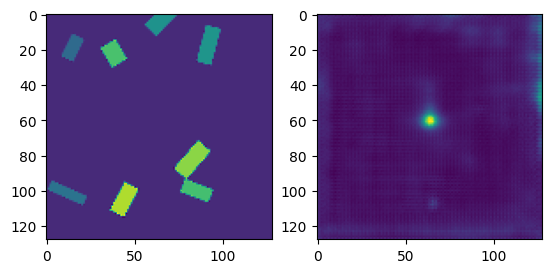

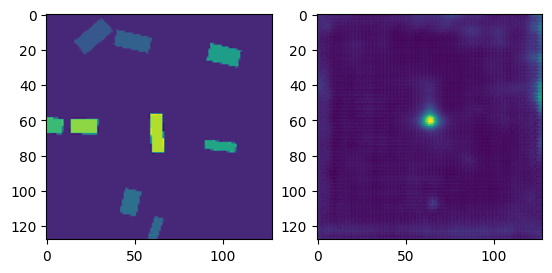

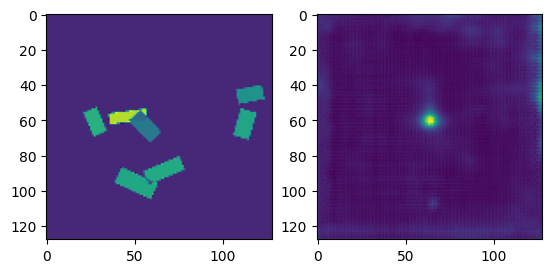

In [8]:
# net.train()
net.eval()
with torch.no_grad():
  for idx in range(5):
    a, b = loaders['test'].dataset.__getitem__(idx)
    with torch.no_grad():
      out = net(a.unsqueeze(0).to(device)).detach().cpu()

    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(b.squeeze().numpy())#'gaussian_lens'
    axes[1].imshow(out.squeeze().numpy())#'gaussian_lens'


In [7]:
a

tensor([[[-0.0102,  0.0151, -0.0136,  ...,  0.0128,  0.0108, -0.0053],
         [-0.0135, -0.0131, -0.0136,  ...,  0.0167,  0.0198, -0.0191],
         [ 0.0151,  0.0051, -0.0152,  ...,  0.0117,  0.0055,  0.0112],
         ...,
         [-0.0130, -0.0191, -0.0172,  ..., -0.0136,  0.0144,  0.0139],
         [-0.0190, -0.0064, -0.0113,  ..., -0.0143,  0.0137,  0.0146],
         [ 0.0193,  0.0130, -0.0159,  ..., -0.0142, -0.0146,  0.0121]]])

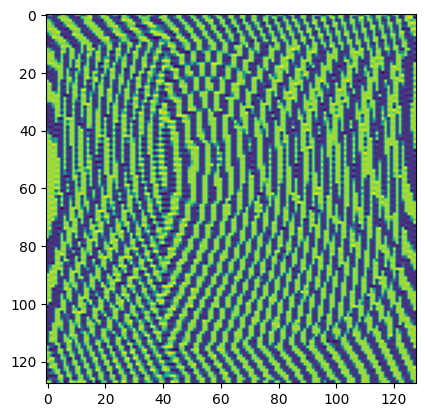

In [6]:
plt.imshow(a.squeeze())

In [25]:
from wavebench.nn.lploss import LpLoss

lp_loss_fun = LpLoss(p=2)
net.eval()
running_loss = 0.0
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, targets]
    inputs, targets = data
    inputs = inputs.to(device)
    targets = targets.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)

    loss = lp_loss_fun(outputs, targets)
    # loss.backward()
    # optimizer.step()
    # scheduler.step()

    # print statistics
    running_loss += loss.item()


In [26]:
running_loss / len(test_loader)

0.641734101176262

: 

In [10]:
lp_loss_fun(outputs, targets)

tensor(1.4891, device='cuda:0', grad_fn=<MeanBackward0>)

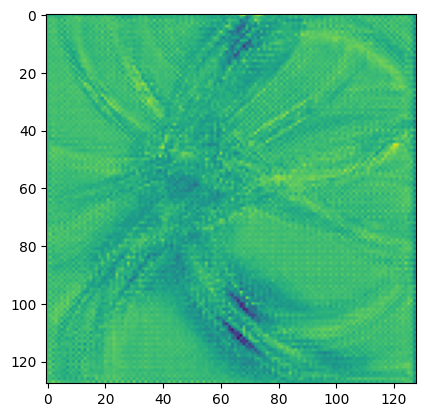

In [11]:
plt.imshow(outputs.detach().cpu().numpy().squeeze())